In [1]:
from CoRe_Dataloader_From_File_With_Random_From_Tensors import get_new_ttv_dataloaders, get_new_test_train_validation_datasets
from CoRe_Dataloader_ECSG import dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,TensorDataset
import math
import torchinfo
import time
import numpy as np
import wandb
import datetime
from collections import OrderedDict

In [2]:
import torchmetrics as metrics
import pandas as pd
mae = metrics.MeanAbsoluteError()
mse = metrics.MeanSquaredError()
combined = metrics.MetricCollection([
    mae, mse
    metrics.MeanAbsolutePercentageError(),
    metrics.MeanSquaredLogError()
])
combined.to("cuda:0")

def get_df_from_rdict(rdict):
    return pd.DataFrame(pd.Series(rdict).map(lambda x: x.item())).T


In [3]:
def calc_metrics(model:torch.nn.Module,dl:DataLoader):
    model.eval()
    raw_output = []
    parameters = []
    with torch.no_grad():
        for batch,(sg,params) in enumerate(dl):
            sg = sg.to("cuda:0").to(torch.float)
            sgsh = sg.shape
            sg = sg.view(sgsh[0], 1, sgsh[1], sgsh[2])

            params = params[:,0].to("cuda:0").to(torch.long)
            
            raw_output.append(model(sg).detach().cpu())
            parameters.append(params.cpu())
            # print(batch)
    model.train()
    output = torch.vstack(raw_output)
    parameters = torch.hstack(parameters)
    return combined(output,parameters)


In [4]:
# import vit
# import vit_pytorch
from vit_pytorch import vit_for_small_dataset as vit_sd
from vit_pytorch import vit as simple_vit
from vit_pytorch.deepvit import DeepViT
def init_model():
    # return simple_vit.ViT(image_size=400,
    #                patch_size=20,
    #                num_classes=19,
    #                dim=int(1024/2),
    #                depth=2,
    #                heads=8,
    #                mlp_dim=int(2048/2),
    #                channels=1).to("cuda:0")
    # return vit_sd.ViT(image_size=400,
    #                patch_size=20,
    #                num_classes=19,
    #                dim=1024,
    #                depth=4,
    #                heads=16,
    #                mlp_dim=int(2048/2),
    #                dropout = 0.1,
    #                emb_dropout = 0,
    #                channels=1).to("cuda:0")
    return DeepViT(image_size=400,
                    patch_size=20,
                    num_classes=2,
                    dim=1024,
                    depth=4,
                    heads=16,
                    mlp_dim=int(2048/2),
                    dropout=0.1,
                    emb_dropout=0.1,
                    channels=1).to("cuda:0")


In [5]:
model = init_model()
img = torch.randn(1,1, 400,400).to("cuda:0")
preds = model(img)  # (1, 1000)
print(preds)
torchinfo.summary(model, input_size=(1,1, 400, 40))

tensor([[ 0.2334,  0.0739, -0.1752,  0.0668, -0.3540, -0.2102,  0.3499,  0.3490,
          0.2714,  0.0628,  1.0866, -0.4875, -0.7810,  0.9733, -0.3499,  0.4128,
         -0.4465,  0.2090,  0.8769]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


C:\Users\aashr\AppData\Roaming\Python\Python310\site-packages\torch\storage.py:315: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.
  warnings.warn(message, UserWarning)


Layer (type:depth-idx)                                       Output Shape              Param #
DeepViT                                                      [1, 19]                   411,648
├─Sequential: 1-1                                            [1, 40, 1024]             --
│    └─Rearrange: 2-1                                        [1, 40, 400]              --
│    └─LayerNorm: 2-2                                        [1, 40, 400]              800
│    └─Linear: 2-3                                           [1, 40, 1024]             410,624
│    └─LayerNorm: 2-4                                        [1, 40, 1024]             2,048
├─Dropout: 1-2                                               [1, 41, 1024]             --
├─Transformer: 1-3                                           [1, 41, 1024]             --
│    └─ModuleList: 2-5                                       --                        --
│    │    └─ModuleList: 3-1                                  --                  

In [6]:
startlr = 3e-5
optimizer = optim.AdamW(params=model.parameters(), lr=startlr)
optimizer1 = optim.NAdam(params=model.parameters(), lr=startlr)
step_scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[1,2,3,4], gamma=0.5)
# at the end of 600 epochs, the learning rate is 0.000,002,62
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, step_size=1, gamma=0.8)
scheduler_pl = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='max', factor=0.7, patience=35, verbose=True)
l1 = nn.L1Loss(reduction = "sum")
l2 = nn.L2Loss(reduction = "sum")
lossfn = lambda x,y: l1(x,y) + l2(x,y)

In [7]:
def to_seconds(s):
    return f"{s//3600}H:{(s%3600)//60}M:{round(s%60,3)}S"
def ismult(n,div):
    return bool(1>>(n%div))

In [ ]:
def save_model(best_model,config,m1,m2,m1name = "l1",m2name = "l2"):
    try:
        torch.save(
            best_model, f"./saved_models/ViT/WithNoise/best_model_state_dict_ViT_regressor_for{config.run_name}_stime_{config.start_time.replace(':', '-')}__{m1name}_{max_acc}__{m2name}_{max_auc}.pt")
        print("\nSAVING MODEL")
    except:
        wandb.alert(level="warning", title="OUT OF MEMORY")

In [8]:
def train_eval_model(config, train_dl, test_dl, adam=True, nadam=False):
    ldl = len(train_dl)
    results = pd.DataFrame()
    best_model = OrderedDict()
    for epoch in range(1,config.epochs+1):
        
        print("preeval finished")
        etime = time.time()
        for batch,(sg,params) in enumerate(train_dl):
            stime = time.time()
            sgsh = sg.shape
            sg = sg.to("cuda:0").to(torch.float).view(sgsh[0],1,sgsh[1],sgsh[2])
            params = params[:,0].to("cuda:0").to(torch.long)
            optimizer.zero_grad()
            outputs = model(sg)
            loss = lossfn(outputs,params)
            loss.backward()
            optimizer.step() if adam else None
            optimizer1.step() if nadam else None
            #
            torch.cuda.empty_cache()
            #
            wandb.log({"loss": loss.item(), "batch_mae": mae(outputs.to(
                "cpu"), params.to("cpu")),"batch_mse":mse(outputs.to(
                "cpu"), params.to("cpu")) "lr": scheduler.get_last_lr()[0], "epoch": epoch})
            
            print(
                f"{epoch:5}/{config.epochs:5} // {batch:5}/{ldl:5} | Loss: {loss.item():2.4},batch_mae:{mae(outputs.to('cpu'),params.to('cpu')):3.4}, lr:{scheduler.get_last_lr()[0]:1.5}, Time per Batch: {time.time()-stime:.3} seconds, Accumulated Time {to_seconds(round(time.time()-etime,3))}    ", end="\r", flush=True)
            
            if (batch-1) % 5000 == 0:
                epoch_results = calc_metrics(model, test_dl)
                results = pd.concat([results, get_df_from_rdict(epoch_results)])
                min_mae = min(results["MeanAbsoluteError"])
                min_mse = min(results["MeanSquaredError"])
                #
                if epoch_results["MeanAbsoluteError"] == min_mae:
                    best_model = model.state_dict()
                    save_model(best_model,config,list(epoch_results.values())[0],list(epoch_results.values())[1])
                    

                wandb.log({"epoch": epoch, "lr": scheduler.get_last_lr()[0]} | epoch_results | {
                        "MinimumMAE": min_mae, "MinimumMSE": min_mse} | {"EpochTime": time.time()-etime})
        #
        scheduler.step()
        step_scheduler.step()
        scheduler_pl.step(max_acc)
        #
        epoch_results = calc_metrics(model, test_dl)
        results = pd.concat([results, get_df_from_rdict(epoch_results)])
        #
        min_mae = min(results["MeanAbsoluteError"])
        min_mse = min(results["MeanSquaredError"])

        if epoch_results["MeanAbsoluteError"] == min_mae:
            best_model = model.state_dict()
            save_model(best_model,config,list(epoch_results.values())[0],list(epoch_results.values())[1])
        #
        
        wandb.log({"epoch": epoch, "lr": scheduler.get_last_lr()[0]} | epoch_results | {
                "MinimumMAE": min_mae, "MinimumMSE": min_mse} | {"EpochTime": time.time()-etime})

    epoch_results = calc_metrics(model, test_dl)
    results = pd.concat([results, get_df_from_rdict(epoch_results)])
    return min_mae,min_mse

In [9]:
# uncomment for training
results = []
trials = 1
for i in range(trials):
    wandb.init(project="deep_vision_transformer_with_noise_classifier_2",)
    config = wandb.config
    config.run_name = wandb.run._run_id
    config = wandb.config
    config.epochs = 3   
    config.inx = 400
    config.iny = 400
    config.lr = startlr     
    config.trial = i+1
    config.total_trials = trials
    config.best_model = OrderedDict()
    config.start_time = datetime.datetime.now().isoformat()
    config.savename = f"best_model_state_dict_at_for{config.run_name}_stime_{config.start_time.replace(':', '-')}__acc_max_acc__auc_auc.pt"
    train_dl, valid_dl, test_dl = get_new_ttv_dataloaders()
    train_eval_model(wandb.config,train_dl,valid_dl,nadam=True)
    results.append(calc_metrics(model,test_dl)) #type: ignore
    if i != (trials - 1):
        model = init_model()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: aashraychegu (alabs). Use `wandb login --relogin` to force relogin


preeval finished
    1/    3 //     1/23769 | Loss: 2.933,batch_accuracy:0.3125, lr:3e-05, Time per Batch: 0.463 seconds, Accumulated Time 0.0H:0.0M:1.002S    
SAVING MODEL
    1/    3 //  5001/23769 | Loss: 0.557,batch_accuracy:0.75, lr:3e-05, Time per Batch: 0.483 seconds, Accumulated Time 0.0H:50.0M:41.86799999999994S           
SAVING MODEL
    1/    3 // 10001/23769 | Loss: 0.458,batch_accuracy:0.9375, lr:3e-05, Time per Batch: 0.48 seconds, Accumulated Time 1.0H:41.0M:38.13600000000042S          
SAVING MODEL
    1/    3 // 15001/23769 | Loss: 0.2754,batch_accuracy:0.9375, lr:3e-05, Time per Batch: 0.475 seconds, Accumulated Time 2.0H:32.0M:31.38500000000022S        
SAVING MODEL
    1/    3 // 20001/23769 | Loss: 0.3831,batch_accuracy:0.875, lr:3e-05, Time per Batch: 0.463 seconds, Accumulated Time 3.0H:23.0M:24.139999999999418S       
SAVING MODEL
    1/    3 // 23768/23769 | Loss: 0.05139,batch_accuracy:1.0, lr:3e-05, Time per Batch: 0.135 seconds, Accumulated Time 10.0H:57.0M

In [10]:
evaldl = test_dl

In [ ]:
model.eval()
raw_output = []
parameters = []
with torch.no_grad():
    for batch,(sg,params) in enumerate(evaldl):
        sg = sg.to("cuda:0").to(torch.float)
        sgsh = sg.shape
        sg = sg.view(sgsh[0], 1, sgsh[1], sgsh[2])

        params = params[:,0].to("cuda:0").to(torch.long)

        raw_output.append(model(sg).detach().cpu())
        parameters.append(params.cpu())
        print(batch,"finished")
model.train()
output = torch.vstack(raw_output)
parameters = torch.hstack(parameters)
output = torch.argmax(output, dim=1)


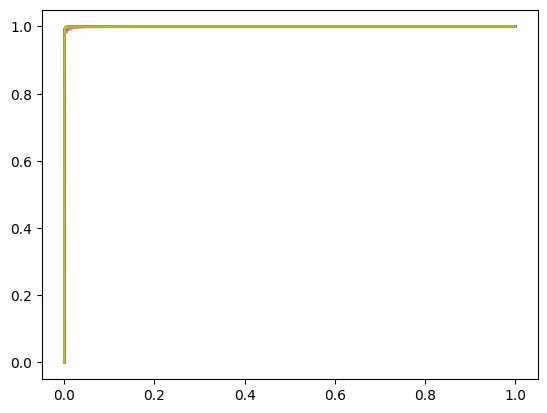

In [12]:
roc = metrics.ROC(task="multiclass",num_classes=19)
fpr, tpr, thresholds = roc(output,parameters)
len(fpr)
import matplotlib.pyplot as plt
for i in range(len(fpr)):
    plt.plot(fpr[i],tpr[i])
plt.show()
torch.save([fpr,tpr,thresholds],"roc.pt")

In [14]:
comparisons = torch.eq(output, parameters).to(torch.float)
torch.mean(comparisons)

tensor(0.9846)

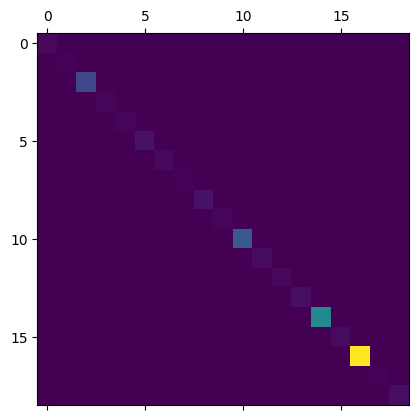

In [93]:
confusion_matrix = metrics.ConfusionMatrix(num_classes=19, task = "multiclass")
cfm = confusion_matrix(output,parameters).requires_grad_(False)
np_cfm = cfm.cpu().numpy()
num_elements = torch.unique(parameters, return_counts=True)[1]
plt.matshow(np_cfm)

In [ ]:
total_in_col = torch.sum(cfm,dim = 1)
divide_by = torch.tensor(np.vstack([total_in_col for i in range(19)]))
rescaled_cfm = cfm/divide_by

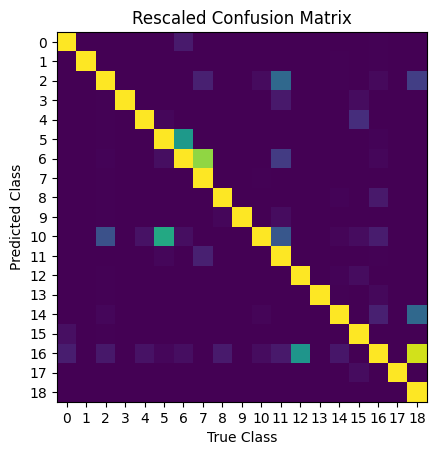

In [116]:
plt.imshow(nn.functional.sigmoid(rescaled_cfm*40))
plt.title("Rescaled Confusion Matrix")
plt.xlabel("True Class")
plt.xticks(np.arange(19))
plt.ylabel("Predicted Class")
plt.yticks(np.arange(19))
plt.show()

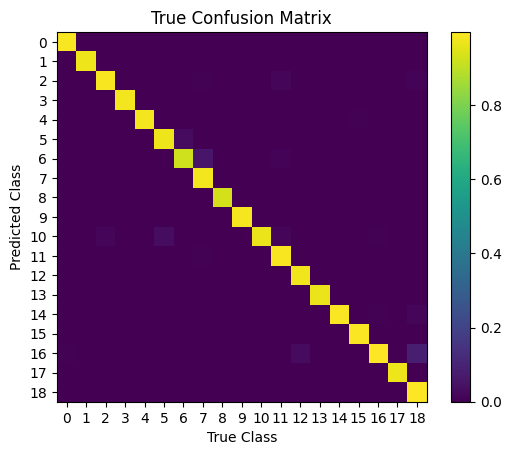

In [120]:
plt.imshow(rescaled_cfm)
plt.title("True Confusion Matrix")
plt.xlabel("True Class")
plt.xticks(np.arange(19))
plt.ylabel("Predicted Class")
plt.yticks(np.arange(19))
plt.colorbar()
plt.show()

In [ ]:
all_params = []
for batch,(sg,params) in enumerate(evaldl):
    all_params.append(params.cpu())
    print(batch,len(evaldl))
all_params = torch.vstack(all_params)
all_params.shape
results = torch.cat((all_params,torch.unsqueeze(comparisons,dim=1)),dim=1)

In [132]:
import pandas as pd
df = pd.DataFrame(results.numpy())
df = df.rename(columns={0: "EOS", 1: "M1", 2: "M2", 3: "SNR", 4: "correct"})
df["combined"] = df["M1"] + df["M2"]
df = df.drop("M1", axis=1).drop("M2", axis=1)
df = df.rename(columns={"combined": "Masses"})
df

,EOS,SNR,correct,Masses
0,16.0,1.380,1.0,2.462582
1,14.0,2.430,1.0,2.888030
2,16.0,2.630,1.0,2.700196
3,16.0,3.580,1.0,2.461393
4,10.0,4.830,1.0,2.750994
...,...,...,...,...
47532,16.0,2.905,1.0,2.701216
47533,14.0,2.605,1.0,2.888030
47534,10.0,0.330,1.0,2.750593
47535,14.0,0.930,1.0,2.700056


In [144]:
mnc = pd.DataFrame([df["Masses"],df["correct"]]).T

In [145]:
mnc

,Masses,correct
43509,2.400,1.0
24304,2.400,1.0
13616,2.400,1.0
46254,2.400,1.0
5698,2.400,1.0
...,...,...
17747,3.438,1.0
19452,3.438,1.0
25686,3.438,1.0
27475,3.438,1.0


In [184]:
massescounts = pd.DataFrame(mnc["Masses"].value_counts())
massescounts = massescounts.rename(columns={"Masses":"counts"})
massescounts = massescounts.rename_axis("masses")
massescounts

,counts
masses,
2.700984,4453
2.700002,2391
2.700000,1647
2.699996,1599
2.700056,1168
...,...
2.400000,27
2.749000,25
2.920000,23


Text(0.5, 1.0, 'Histogram of Masses')

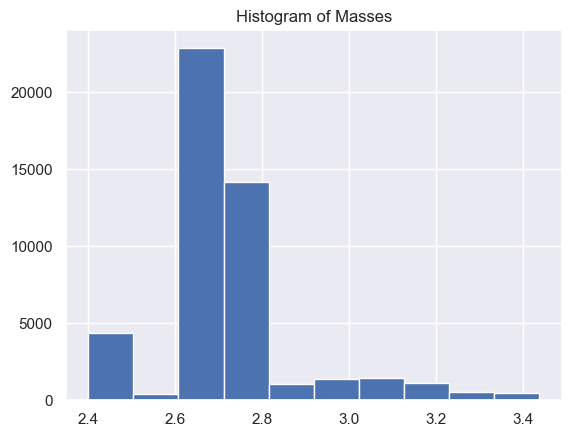

In [196]:
plt.hist(mnc["Masses"],bins=10)
plt.title("Histogram of Masses")

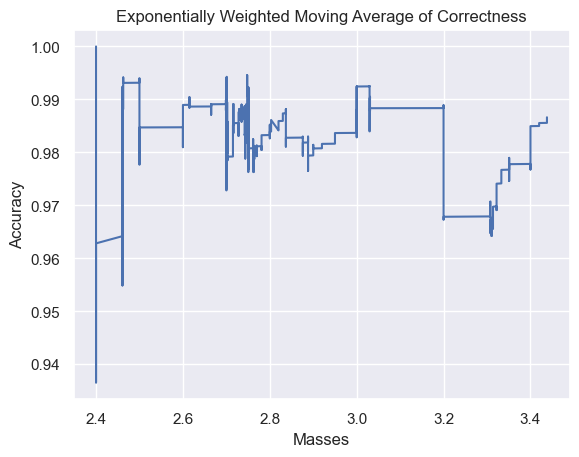

In [193]:
mnc["ewma1"] = mnc["correct"].ewm(span = 1000).mean()
plt.plot(df["Masses"],df["ewma1"])
plt.title("Exponentially Weighted Moving Average of Correctness")
plt.xlabel("Masses")
plt.ylabel("Accuracy")
plt.show()

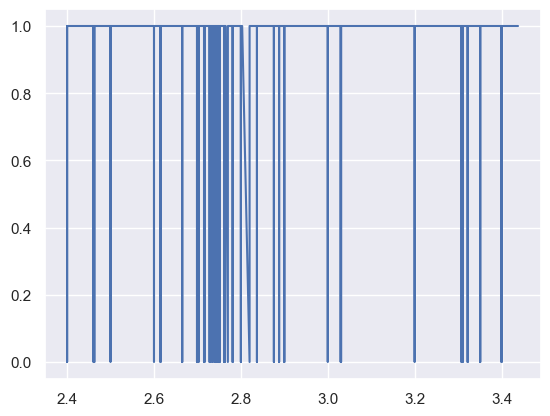

In [135]:
df.sort_values(by=["Masses"], inplace=True)
plt.plot(df["Masses"], df["correct"])

In [137]:
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


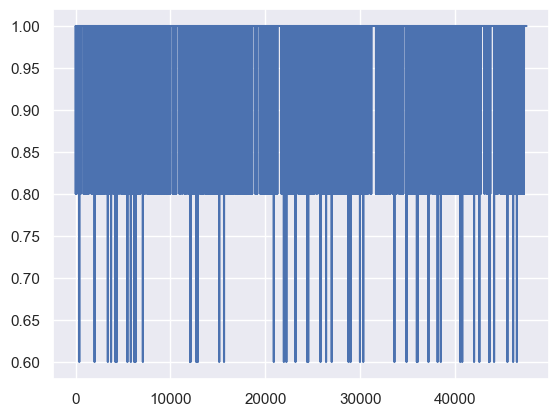

In [141]:
a = moving_average(df["correct"].to_numpy(), 5)
plt.plot(a)

In [37]:

by_eos_filter = {}
for i in df["EOS"].unique():
    # print(df[df["EOS"] == i].mean()["correct"])
    by_eos_filter[i] = [df[df["EOS"] == i].mean()["correct"]]

eosdf = pd.DataFrame(by_eos_filter)
eosdf = eosdf.reindex(sorted(eosdf.columns), axis=1)
remapper = {value: key for key, value in dataset.eosmap.items()}
eosdf = eosdf.rename(columns=remapper)
eosdf


,2B,2H,ALF2,BHBlp,BLQ,BLh,DD2,ENG,G2,G2k123,H4,LS220,MPA1,MS1,MS1b,SFHo,SLy,SLy4,sly
0,0.985972,0.982143,0.983547,0.98913,0.989873,0.988406,0.982175,0.982759,0.988848,0.980519,0.982591,0.982487,0.992771,0.976996,0.984436,0.986971,0.985333,0.969388,0.985115


In [38]:
by_snr_filter = {}
for i in df["SNR"].unique():
    # print(df[df["EOS"] == i].mean()["correct"])
    by_snr_filter[i] = [df[df["SNR"] == i].mean()["correct"]]

snrdf = pd.DataFrame(by_snr_filter)
snrdf = snrdf.reindex(sorted(snrdf.columns), axis=1)
# remapper = {value: key for key, value in dataset.eosmap.items()}
# eosdf.rename(columns=remapper)
# eosdf
snrdf.rename(columns={0.000: -1}).T
snrdf


,0.000,0.005,0.030,0.055,0.080,0.105,0.130,0.155,0.180,0.205,...,4.755,4.780,4.805,4.830,4.855,4.880,4.905,4.930,4.955,4.980
0,0.988971,0.965957,0.991597,0.971311,0.982456,0.981567,0.991837,0.995708,0.984252,0.976378,...,0.953846,0.979424,0.979424,0.9875,0.973684,0.987124,0.975,0.982759,0.995851,0.9869


In [ ]:

df.to_csv("total_corrects_and_factors.pd.csv")
eosdf.to_csv("accuracy_by_eos.pd.csv")
snrdf.to_csv("accuracy_by_signal-to-noise-ratio.pd.csv")
